<a href="https://colab.research.google.com/github/Farouk96/Predict_tags_question/blob/main/P5_02_notebooktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib import pyplot
import pickle

import time

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
#One Vs rest
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import Perceptron,LogisticRegression,LogisticRegressionCV,SGDClassifier,PassiveAggressiveClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.svm import LinearSVC 


#Multioutput
from sklearn.multioutput import MultiOutputClassifier

from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier

from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier



#Score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score, make_scorer

from sklearn.model_selection import GridSearchCV

from scipy.sparse import hstack

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ P5_HADJ NACER_Farouk/Questions_Tags_Exploration.csv', sep=',')

# Data preparation


*   Binariser les tags
*   Utiliser un TFIDF pour body et Title Les paramètres du TFIDF sont très importants pour la performance de nos tags puisque nous ne voulons pas qu'il supprime des mots comme c# ou .net. Pour cela, nous devons utiliser le motif suivant : token_pattern=r"(?u)\S\S+"


In [ ]:
X1 = data['Body']
X2 = data['Title']
y = data['Tags']

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [ ]:
multilabel_binarizer.classes_

array([' ', '#', "'", '+', ',', '-', '.', '2', '3', '4', '<', '[', ']',
       'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype=object)

In [ ]:
with open('Multi_label.pkl','wb') as S:
  pickle.dump(multilabel_binarizer,S)

In [ ]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=5000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=5000)

In [ ]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [ ]:
with open('Vectorizer question1.pkl','wb') as S:
  pickle.dump(vectorizer_X1,S)
with open('Vectorizer question2.pkl','wb') as T:
  pickle.dump(vectorizer_X2,T)  

In [ ]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
y_train.shape

(9784, 39)

In [ ]:
y_test.shape

(2446, 39)

#PCA

In [ ]:
X_tfidftodense = X_tfidf.todense()

In [ ]:
pca = PCA(n_components=1000).fit(X_tfidftodense)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


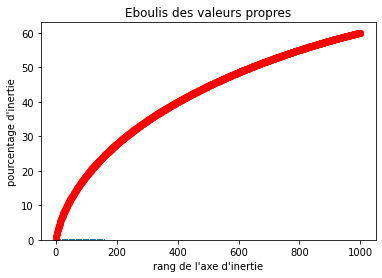

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)

In [ ]:
pca_train, pca_test, y_train, y_test = train_test_split(pca, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

#Trunced svd


In [ ]:
svd= TruncatedSVD()
svd=svd.fit_transform(X_tfidf)

In [ ]:
svd_train, svd_test, y_train, y_test = train_test_split(svd, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
svd_train.shape

(9784, 2)

In [ ]:
svd_test.shape

(2446, 2)

#Modélisation supérvisé

In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("F1-score: {}".format(f1_score(y_test, y_pred,average='micro')))
    print("---")  

##One vs Rest
Pour évaluer nos modèles, j'utiliserai **le score de Jacard** car il est le mieux adapté à la classification multi-étiquettes.

In [ ]:
perceptron=Perceptron()
lr=LogisticRegression()
sgd=SGDClassifier()
svc=LinearSVC()

In [ ]:
for classifier in [sgd, lr, svc, perceptron]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  SGDClassifier
Jacard score: 71.08278646171175
F1-score: 0.8216874456364164
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LogisticRegression
Jacard score: 70.16204722883528
F1-score: 0.8148087125580782
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LinearSVC
Jacard score: 69.67745115726837
F1-score: 0.8122020060276506
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  Perceptron
Jacard score: 65.82849346931233
F1-score: 0.7870110105135651
---


###avec PCA


In [ ]:
for classifier in [sgd, lr, svc, perceptron]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(pca_train, y_train)
    y_pred = clf.predict(pca_test)
    print_score(y_pred, classifier)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  SGDClassifier
Jacard score: 58.9374423839739
F1-score: 0.7352038804998028
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LogisticRegression
Jacard score: 59.68775893277732
F1-score: 0.7399182561307903
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LinearSVC
Jacard score: 59.824700843586974
F1-score: 0.7403860898604556
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  Perceptron
Jacard score: 51.826485668761755
F1-score: 0.6790947996368825
---


###avec SVD

In [ ]:
perceptron=Perceptron()
lr=LogisticRegression()
sgd=SGDClassifier()
svc=LinearSVC() 


for classifier in [sgd, lr, svc, perceptron]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(svd_train, y_train)
    y_pred = clf.predict(svd_test)
    print_score(y_pred, classifier)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  SGDClassifier
Jacard score: 47.03935290571275
F1-score: 0.6376984894578578
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LogisticRegression
Jacard score: 47.7847676802807
F1-score: 0.6458504232481019
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  LinearSVC
Jacard score: 47.821595825379845
F1-score: 0.6462402343750001
---


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 2 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 10 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 12 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


Clf:  Perceptron
Jacard score: 46.050215548764754
F1-score: 0.6327602027769003
---


##Multi output

In [ ]:
DT=DecisionTreeClassifier()
ETC=ExtraTreeClassifier()
KNC=KNeighborsClassifier()
RF=RandomForestClassifier()

In [ ]:
for classifier in [DT,ETC,KNC,RF]:
    clf = MultiOutputClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DecisionTreeClassifier
Jacard score: 63.269287920252204
F1-score: 0.7738100766194567
---
Clf:  ExtraTreeClassifier
Jacard score: 58.976181794313064
F1-score: 0.741775140575973
---
Clf:  KNeighborsClassifier
Jacard score: 54.245417173556085
F1-score: 0.6876184920519177
---
Clf:  RandomForestClassifier
Jacard score: 71.40490701744669
F1-score: 0.8255984367366879
---


###avec PCA

In [ ]:
for classifier in [DT,ETC,KNC,RF]:
    clf = MultiOutputClassifier(classifier)
    clf.fit(pca_train, y_train)
    y_pred = clf.predict(pca_test)
    print_score(y_pred, classifier)

Clf:  DecisionTreeClassifier
Jacard score: 51.27231615102592
F1-score: 0.6744790075169591
---
Clf:  ExtraTreeClassifier
Jacard score: 48.698375254319906
F1-score: 0.6530143364783728
---
Clf:  KNeighborsClassifier
Jacard score: 57.546793726237574
F1-score: 0.7164464738370628
---
Clf:  RandomForestClassifier
Jacard score: 60.94809288680193
F1-score: 0.7487581522657385
---


###avec SVD

In [ ]:
for classifier in [DT,ETC,KNC,RF]:
    clf = MultiOutputClassifier(classifier)
    clf.fit(svd_train, y_train)
    y_pred = clf.predict(svd_test)
    print_score(y_pred, classifier)

Clf:  DecisionTreeClassifier
Jacard score: 43.4823532538258
F1-score: 0.60620466500023
---
Clf:  ExtraTreeClassifier
Jacard score: 43.60416217056595
F1-score: 0.6079888957433683
---
Clf:  KNeighborsClassifier
Jacard score: 47.34388472366341
F1-score: 0.6407222397397813
---
Clf:  RandomForestClassifier
Jacard score: 47.045092484639056
F1-score: 0.638675359757216
---


##GridSearch CV on the best classifier

In [ ]:
param_grid = {'estimator__alpha':np.logspace(-10, 0,10),
              'estimator__penalty':["l1","l2","elasticnet"]
              } 

In [ ]:
sgd = OneVsRestClassifier(SGDClassifier())
CV_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5,verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_sgd.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START estimator__alpha=1e-10, estimator__penalty=l1..............
[CV 1/5; 1/30] END estimator__alpha=1e-10, estimator__penalty=l1;, score=45.732 total time=   9.0s
[CV 2/5; 1/30] START estimator__alpha=1e-10, estimator__penalty=l1..............
[CV 2/5; 1/30] END estimator__alpha=1e-10, estimator__penalty=l1;, score=46.791 total time=   8.2s
[CV 3/5; 1/30] START estimator__alpha=1e-10, estimator__penalty=l1..............
[CV 3/5; 1/30] END estimator__alpha=1e-10, estimator__penalty=l1;, score=45.996 total time=   8.2s
[CV 4/5; 1/30] START estimator__alpha=1e-10, estimator__penalty=l1..............
[CV 4/5; 1/30] END estimator__alpha=1e-10, estimator__penalty=l1;, score=47.682 total time=   8.3s
[CV 5/5; 1/30] START estimator__alpha=1e-10, estimator__penalty=l1..............
[CV 5/5; 1/30] END estimator__alpha=1e-10, estimator__penalty=l1;, score=45.848 total time=   8.4s
[CV 1/5; 2/30] START estimator__alpha=

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SGDClassifier()),
             param_grid={'estimator__alpha': array([1.00000000e-10, 1.29154967e-09, 1.66810054e-08, 2.15443469e-07,
       2.78255940e-06, 3.59381366e-05, 4.64158883e-04, 5.99484250e-03,
       7.74263683e-02, 1.00000000e+00]),
                         'estimator__penalty': ['l1', 'l2', 'elasticnet']},
             scoring=make_scorer(avg_jacard), verbose=10)

In [ ]:
CV_sgd.best_params_

{'estimator__alpha': 3.5938136638046256e-05, 'estimator__penalty': 'l1'}

In [ ]:
CV_sgd.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=3.5938136638046256e-05,
                                            penalty='l1'))

In [ ]:
best_model = CV_sgd.best_estimator_
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 51.129054238212056
F1-score: 0.6375168690958165
---


In [ ]:
best_model= OneVsRestClassifier(SGDClassifier(alpha=3.5938136638046256e-05,
                                            penalty='l1'))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 51.86777245648872
F1-score: 0.6408422189229316
---


In [ ]:
with open('Best tager questions.pkl','wb') as f:
  pickle.dump(best_model,f)

In [ ]:
best_model.n_features_in_

10000